In [13]:
import lightgbm as lgb
import hyperopt as hp
from numpy.random import RandomState
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
"font.family": 'serif', # 衬线字体
"font.serif": ['SimSun'], # 宋体
"mathtext.fontset": 'stix', # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)

In [31]:
train = pd.read_csv(filepath_or_buffer="../Desktop/essay process/train.csv")
train = pd.DataFrame(train)
test = pd.read_csv(filepath_or_buffer="../Desktop/essay process/test.csv")
test = pd.DataFrame(test)

In [32]:
train.columns

Index(['CoughAndFever', 'NoCoughNoFever', 'NoCoughFever', 'CoughNoFever',
       'Fat', 'B14', 'B15', 'B16', 'goB14', 'goB15', 'goB16', 'weight',
       'height', 'CoughOrNot', 'FeverOrNot'],
      dtype='object')

In [4]:
def  params_append(params):
    params['objective'] = 'binary'
    params['metric'] = 'auc'
    params['feature_pre_filter']=False
    return params

In [5]:
def param_hyperopt(train):
    label = [f for f in train.columns if f in ['illOrNot']]
    features = [f for f in train.columns if f not in ['illOrNot']]
    train_data = lgb.Dataset(train[features],train[label],silent=True)
    def hyperopt_objective(params):
        params = params_append(params)
        print(params)
        res = lgb.cv(params,train_data,1000,nfold=2,stratified=False,shuffle=True,metrics='auc',
                     early_stopping_rounds=20,verbose_eval=False,show_stdv=False)
        return max(res['roc'])
    #参数空间
    params_space = {
        'learning_rate': hp.hp.uniform('learning_rate',1e-2,5e-1),
        'bagging_fraction': hp.hp.uniform('bagging_fraction',0.5,1),
        'feature_fraction': hp.hp.uniform('feature_fraction',0.5,1),
        'num_leaves': hp.hp.choice('num_leaves',list(range(10,300,10))),
        'reg_alpha': hp.hp.randint('reg_alpha',0,10),
        'reg_lambda': hp.hp.uniform('reg_lambda',0,10),
        'bagging_freq': hp.hp.randint('bagging_freq',1,10),
        'min_child_samples': hp.hp.choice('min_child_samples',list(range(1,30,5)))
    }
    params_best = hp.fmin(
        hyperopt_objective,
        space=params_space,
        algo=hp.tpe.suggest,
        max_evals=3000,
#         rstate=RandomState(2020)
    )
    return params_best

In [39]:
params = param_hyperopt(train)

{'bagging_fraction': 0.5799233310707267, 'bagging_freq': 8, 'feature_fraction': 0.5707736578051084, 'learning_rate': 0.3996858776222963, 'min_child_samples': 11, 'num_leaves': 170, 'reg_alpha': 6, 'reg_lambda': 5.333175023522404, 'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False}
[LightGBM] [Info] Number of positive: 484, number of negative: 966                                                     
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566                                                                                       
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 15                            
[LightGBM] [Info] Number of positive: 483, number of negative: 967                                                     
[LightGBM] [Warning] Auto-choosing col-wise

d:\python\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

d:\python\lib\site-packages\lightgbm\basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

d:\python\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

job exception: 

  0%|                                                                         | 0/3000 [00:00<?, ?trial/s, best loss=?]


KeyError: 'roc'

In [6]:
params={'bagging_fraction': 0.9529150842977923,
 'bagging_freq': 8,
 'feature_fraction': 0.9998411903556345,
 'learning_rate': 0.03215789597045231,
 'min_child_samples': 1,
 'num_leaves': 150,
 'reg_alpha': 9,
 'reg_lambda': 5.592470608268405,
 'objective': 'binary',
 'metric': 'auc',
 'feature_pre_filter': False}

In [22]:
ESR = 30
NBR = 10000
VBE = 50
params = params_append(params)
kf = sk.model_selection.KFold(n_splits=5,random_state=2020,shuffle=True)

evals_result = {}

label = [f for f in train.columns if f in ['illOrNot']]
features = [f for f in train.columns if f not in ['illOrNot']]
for train_part_index,eval_index in kf.split(train[features],train[label]):
        eval = lgb.Dataset(train[features].loc[eval_index],train[label].loc[eval_index])
        train_part = lgb.Dataset(train[features].loc[train_part_index],train[label].loc[train_part_index])
        bst = lgb.train(params,train_part,num_boost_round=NBR,valid_sets=[train_part,eval],
                        evals_result=evals_result,
                valid_names=['train','valid'],early_stopping_rounds=ESR,verbose_eval=VBE)

d:\python\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\python\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
d:\python\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future releas

[LightGBM] [Info] Number of positive: 778, number of negative: 1542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 2320, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335345 -> initscore=-0.684109
[LightGBM] [Info] Start training from score -0.684109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 2320, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336638 -> initscore=-0.678313
[LightGBM] [Info] Start training from score -0.678313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

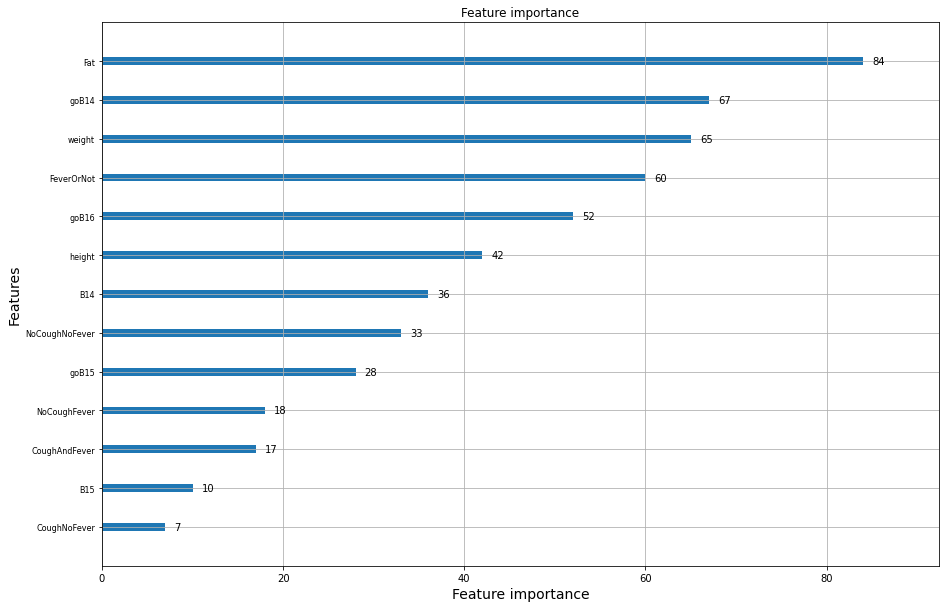

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
lgb.plot_importance(bst, max_num_features=20, ax=ax
                    #,importance_type='gain'
                   )
plt.yticks(fontsize=8)
plt.xlabel('Feature importance',fontsize=14)
plt.ylabel('Features',fontsize=14)
plt.savefig("feature importance.svg", format="svg")

Plotting metrics recorded during training...


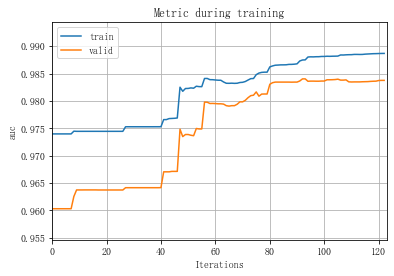

In [16]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.savefig("training progress.png", format="png")

Plotting 4th tree...


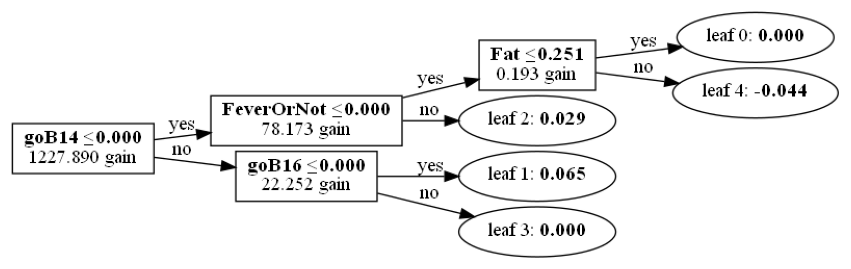

In [15]:
print('Plotting 4th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(bst, tree_index=4, figsize=(15, 15), show_info=['split_gain'])
plt.savefig("training tree.png", format="png")

Plotting split value histogram...


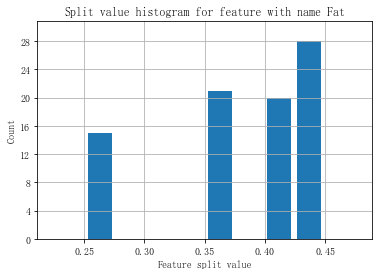

In [17]:
print('Plotting split value histogram...')
ax = lgb.plot_split_value_histogram(bst,feature='Fat', bins='auto')
plt.savefig("training histogram.png", format="png")


In [18]:
def train_predict(train,test,params):
    label = 'illOrNot'
    features = [f for f in train.columns if f not in 'illOrNot']
    params = params_append(params)
    kf = sk.model_selection.KFold(n_splits=5,random_state=2020,shuffle=True)
    prediction_test = 0
    cv_score = []
    prediction_train = pd.Series()
    ESR = 30
    NBR = 10000
    VBE = 50
    for train_part_index,eval_index in kf.split(train[features],train[label]):
        train_part = lgb.Dataset(train[features].loc[train_part_index],train[label].loc[train_part_index])
        eval = lgb.Dataset(train[features].loc[eval_index],train[label].loc[eval_index])
        bst = lgb.train(params,train_part,num_boost_round=NBR,valid_sets=[train_part,eval],
                        valid_names=['train','valid'],early_stopping_rounds=ESR,verbose_eval=VBE)
        prediction_test += bst.predict(test[features])
        prediction_train = prediction_train.append(pd.Series(
        bst.predict(train[features].loc[eval_index]), index=eval_index))
        eval_pre = bst.predict(train[features].loc[eval_index])
        score = np.sqrt(sk.metrics.mean_absolute_error(train[label].loc[eval_index].values,eval_pre))
        cv_score.append(score)
        pd.Series(prediction_train.sort_index().values).to_csv(
        "../Desktop/train_lightgbm1.csv",index = False)
        pd.Series(prediction_test).to_csv("../Desktop/test_lightgbm1.csv",index=False)
        test['illOrNot'] = prediction_test
        test[['illOrNot']].to_csv("../Desktop/submission_lightgbm1.csv",index=False)
        return

In [49]:
train_predict(train,test,params)

[LightGBM] [Info] Number of positive: 778, number of negative: 1542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 2320, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335345 -> initscore=-0.684109
[LightGBM] [Info] Start training from score -0.684109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

C:\Users\86153\AppData\Local\Temp/ipykernel_14364/2901959919.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction_train = pd.Series()
d:\python\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\python\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


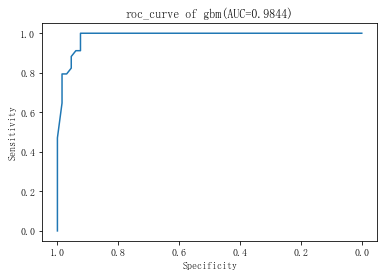

In [80]:
test_part = lgb.Dataset(test)
gbm_y_pre = pd.read_table(filepath_or_buffer="../Desktop/essay process/test answer.txt")
gbm_y_proba = bst.predict(test) # 分类的类别

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve


gbm_auc = roc_auc_score(gbm_y_pre['illOrNot'], gbm_y_proba[:,])  # 计算auc
gbm_fpr, gbm_tpr, gbm_threasholds = roc_curve(gbm_y_pre['illOrNot'], gbm_y_proba[:,])  # 计算ROC的值
plt.title("roc_curve of %s(AUC=%.4f)" % ('gbm', gbm_auc))
plt.xlabel('Specificity')  # specificity = 1 - np.array(gbm_fpr))
plt.ylabel('Sensitivity')  # sensitivity = gbm_tpr
plt.plot(list(1 - np.array(gbm_fpr)), gbm_tpr)
plt.gca().invert_xaxis()  # 将X轴反转
plt.savefig("auc")

0     1
1     1
2     1
3     0
4     0
     ..
95    1
96    1
97    0
98    1
99    0
Name: illOrNot, Length: 100, dtype: int64